# polymake and Optimization

By Sebastian Pokutta and Marc E. Pfetsch.

## Introduction

Polymake offers many interesting features that can help (discrete) optimizers to analyze optimization problems. For example

*  linear optimization can be performed exactly and visualized in small dimensions

*  the convex hull of feasible points of an integer program can be computed and analyzed

*  Hilbert bases can be computed

There are several other tutorials that cover similar topics:

*  [ILP and Hilbert Bases](ilp_and_hilbertbases.ipynb)

*  [Gomory Cuts](branchnbound.ipynb)

*  [Branch and Bound](gomory.ipynb)

*  [Tutorial for Lattice Polytopes](lattice_polytopes_tutorial.ipynb)

This tutorial is targeted towards the optimization community, since, surprisingly, polymake does not seem to be well known in this community. In particular, the community still tends to use the quite old program `porta` to compute convex hulls or inequality descriptions. While `porta` still does a decent job here, `polymake` offers a much broader feature set. Polymake supports several convex hull algorithms which might be better suited depending on the data. Moreover it offers many visualization tools that can help to better *understand* a given polytope. We think that polymake has many advantages for discrete optimizers and hope that this tutorial will help to spread the usage of polymake.

You can find files of the example LPs in the folder demo/files/optimization in your polymake directory. 

## Input: lp2poly

The first important step is to get the desired input into `polymake`. While it is possible to define polytopes in `polymake` right away, a more convenient methods, especially for people working in discrete optimization, is the possibility to read an optimization problem from a file. This has the advantage that input that is usually generated outside `polymake` can simply be loaded. A standard file format for linear (integer) programs is the so-called CPLEX LP-format, which is well known in the optimization community and can be read into `polymake` in a very straightforward way as shown in the following example:

    
    Minimize
     obj:  x1 + x2 + x3
    Subject to
     C1: x1 + x2 + x3 <= 2
    Bounds
     0 <= x1 <= 1
     0 <= x2 <= 1
     0 <= x3 <= 1
    End


Thus, the file describes a 0/1-cube in three dimensions. It should be easy to adapt this format to other cases (If for example `x1` does not have any bounds you can write `x1 free` instead).

Now assume that this example is contained in file `c3t.lp`. We create a polytope from the file via:

In [1]:
$f=lp2poly('files/optimization/c3t.lp');


The polytope `$f` is coded via floating point numbers:

    


In [2]:
print $f->type->full_name;

Polytope<Rational>


We convert it to a rational polytope via:

    


In [3]:
$p = new Polytope<Rational>($f);



Now, `$p` contains data for the linear optimization problem in the file `ct3.lp`. The corresponding polyhedron is stored directly in `$p`. The information about the linear objective is contained in `$p->LP`.


## Linear Optimization

Polymake can be used to perform several actions related to linear optimization (linear programming - LP). For instance, one can exactly solve a linear program (via lrs or cdd). Before we explain the corresponding usage, we first need to have a linear optimization problem at hand.

Assuming that we are given the above example in variable `$p`, the linear objective can be accessed via

    


In [4]:
print $p->LP->LINEAR_OBJECTIVE;

0 1 1 1

Thus - as described in the file - the objective function coefficients are 1 for all three variables (and there is an offset of 0).

Now, we can solve the corresponding linear program via

    


In [5]:
print $p->LP->MAXIMAL_VALUE;

2

Click here for additional output 
 
polymake: used package lrs
 Implementation of the reverse search algorithm of Avis and Fukuda.
 Copyright by David Avis.
 http://cgm.cs.mcgill.ca/~avis/C/lrs.html

Thus, the maximal value that we can obtain via the above linear objective function is 2. We can also get an optimal vertex via

    


In [6]:
print $p->LP->MAXIMAL_VERTEX;

1 0 1 1

This vertex corresponds to setting `x1=0, x2=1, x3=1`. The optimal face can also be computed:

    


In [7]:
print $p->LP->MAXIMAL_FACE;

{0 1 5}

This means that the optimal face is the convex hull of three vertices (with indices 4, 5, 6).

Of course, by replacing `MAXIMAL` by `MINIMAL`, we obtain the corresponding values for minimization.

The directed graph obtained by directing the graph of the polytope in the direction of increasing objective function can be obtained via

    


In [8]:
$p->VISUAL->DIRECTED_GRAPH;

<!--
polymake for knusper
Wed May 20 13:30:23 2020
c3t
-->


 
 
 c3t 
 
 

 

 
 
 Explode 
 
 Automatic explosion 
 Exploding speed 
 
 

 
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 

 


 
 Display 
 
 
 Labels 
 
 


 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

Click here for additional output 
 
polymake: used package threejs
 Three.js is a lightweight cross-browser JavaScript library/API used to create and display animated 3D computer graphics on a Web browser.
 See http://github.com/mrdoob for the source code.

The minimal and maximal faces can be visualized via

In [9]:
$p->VISUAL->MIN_MAX_FACE;

<!--
polymake for knusper
Wed May 20 13:30:23 2020
c3t
-->


 
 
 c3t 
 
 

 

 
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 

 


 
 Display 
 
 
 Labels 
 
 


 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

## Computing Facets

An important action that is often needed to come up with new facet describing inequalities for combinatorial optimization problems is the computation of convex hulls for small examples.

### Pure Integer Case

We begin with the case in which all variables are required to be integral, i.e., the *pure integer case*. Moreover, the approach depends on whether the polyhedron is bounded or not.

#### Bounded Polyhedra

Let us illustrate the approach via the example of the *stable set problem*: Here one is given an (undirected) Graph G = (V,E) with node set V and edges E. The goal is to find a largest subset of nodes V' such that any two nodes in V' are not connected by an edge.

For our example consider the 5-cycle, i.e., the graph C<sub>5</sub> with five nodes {1, 2, 3, 4, 5} and edges {1,2}, {2,3}, {3,4}, {4,5}, {5,1}. A formulation of the stable set problem for this graph looks as follows:

    
    Maximize
     obj: x#1 + x#2 + x#3 + x#4 + x#5
    Subject to
     edge_1: x#2 + x#1 <= 1
     edge_2: x#3 + x#2 <= 1
     edge_3: x#4 + x#3 <= 1
     edge_4: x#5 + x#4 <= 1
     edge_5: x#1 + x#5 <= 1
    Bounds
     0 <= x#1 <= 1
     0 <= x#2 <= 1
     0 <= x#3 <= 1
     0 <= x#4 <= 1
     0 <= x#5 <= 1
    General
     x#1 x#2 x#3 x#4 x#5
    End

Here, `General` encodes that the following variables should be restricted to obtain integer values. Thus, all variables `x#1, x#2, x#3, x#4, x#5` are restricted to binary values (0 or 1). The value 1 encodes that the corresponding node will be in an optimal stable set (and 0 otherwise). The constraints `edge_*` encode that a most one of the two nodes covered by an edge is selected. Clearly, the corresponding polyhedron is bounded.

We assume that the above information is contained in the file `stab.lp`. We now read it into polymake and convert it to rational form, as explained above:

    


In [10]:
$f=lp2poly('files/optimization/stab.lp');
$p = new Polytope<Rational>($f);



We are now interested in all feasible solutions to the above problem, i.e., all assignments of 0 or 1 to the variables such that the above inequalities are satisfied. These feasible points can be computed via:

    


In [11]:
$p->LATTICE_POINTS;


To understand these points and make computational use of this information, we are interested in the convex hull of all feasible solutions. To this end, we construct a new polytope which is specified via points for which the convex hull is taken. This can be done as follows:

    


In [12]:
$s=new Polytope(POINTS=>$p->LATTICE_POINTS, COORDINATE_LABELS=>$p->COORDINATE_LABELS);


Here, the coordinate labels, i.e., the variable names, are copied to the new polytope.

Now, the facets of the new polytope can be computed and listed via:

    


In [13]:
print_constraints($s);

Facets:
0: -x#1 - x#5 >= -1
1: -x#1 - x#2 >= -1
2: -1/2 x#1 - 1/2 x#2 - 1/2 x#3 - 1/2 x#4 - 1/2 x#5 >= -1
3: x#2 >= 0
4: x#5 >= 0
5: -x#3 - x#4 >= -1
6: x#4 >= 0
7: -x#2 - x#3 >= -1
8: x#1 >= 0
9: x#3 >= 0
10: -x#4 - x#5 >= -1



The facet defining inequalities can be interpreted as follows:

*  There are five trivial inequalities `x#? >= 0`.

*  The five original 'edge' inequalities `x#i + x#j <= 1` define facets.

*  We have the so-called *odd-cycle inequality* `x#1 +x#2 + x#3 + x#4 + x#5 <= 2`, stating that at most two nodes in an (odd) cycle of length 5 can be selected. This inequality can be generalized by taking the sum of all variables in an odd cycle and restricting the sum to be less or equal to the size of the cycle minus 1 divided by 2.

Of course, one can also use the usual polymake output, e.g., `print $s->FACETS`.

This example showed one of the routine actions often performed by discrete optimizers. Of course, this action can also be performed by a script, which makes the computation a one-line command.

Note that the size of instances that can be handled will probably be small. Usually, things become difficult from dimension 15 on, but it depends on the particular structure of your instances, i.e., on the number of facets and lattice points.


#### Unbounded Polyhedra

If the underlying polyhedron is unbounded, the approach above does not work anymore, since there are infinitely many lattice points. Arguably,  this case occurs less often than the bounded case, but it is a excellent show-case for polymake's potential.

The following mathematical insights are important to treat the unbounded case. First, we have to assume that the data, i.e., the inequality description of the polyhedron `P`, is rational; otherwise, we cannot expect a finite description of the convex hull. Second, we write `P` as the sum of a finite part `Q` and the recession cone `C`. If the data is rational, the recession cone of `P` and of the integer hull coincide. Third, it suffices to generate the integer points in `Q + R`, where `R` is the parallelotope generated by the rays of `C`. Thus, `R` is generated by the Minkowski sum of the interval `[0,1]` and the generating rays.

To illustrate the construction, consider the following example:

    
    Minimize
     obj:  x1 + x2
    Subject to
    C1: x1 + x2 >= 0.5
    C2: x1 - 2 x2 <= 1.5
    C3: x2 - 2 x1 <= 1.5
    General
     x1 x2
    End
    
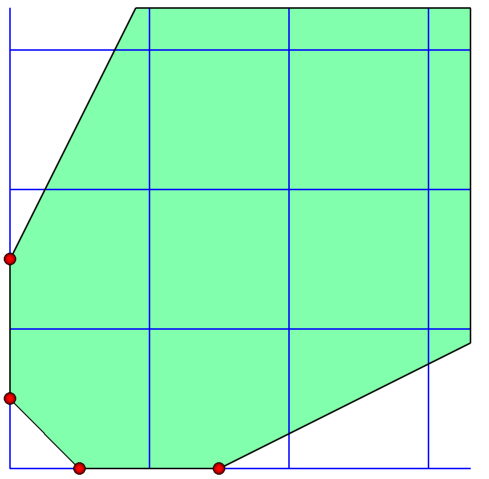<img>

We now assume that the example is contained in the file `unbounded.lp` and proceed as above


In [14]:
$f = lp2poly('files/optimization/unbounded.lp');
$pin = new Polytope<Rational>($f);


The visualization in the picture can be generated with `$pin->VISUAL`. The lattice points can be shown with `$pin->VISUAL->LATTICE_COLORED`.

We now extract the rays of the recession cone

    


In [15]:
$rays = $pin->VERTICES->minor($pin->FAR_FACE, All);


This command first computes all vertices of the polyhedron (this includes unbounded vertices); note that is involves a convex hull computation. The set `FAR_FACE` contains the indices of all vertices that are unbounded. The result is:

    


In [16]:
print $rays;

0 1 1/2
0 1 2


Thus, there are two rays that are generators of the recession cone.

We now have to construct the Minkowski hull of all intervals `[0,r]` for each ray `r` (scaled to be integral). This can be done with the following code (possibly easier):

In [17]:
$zero = unit_vector<Rational>($pin->DIM + 1, 0);
$B = new Polytope<Rational>(POINTS=>$zero);
foreach my $r (@$rays)
{
    $M = new Matrix<Rational>(primitive($r));
    $M->[0]->[0] = 1;
    $M = $M / $zero;
    $ptemp = new Polytope<Rational>(POINTS=>$M);
    $B = minkowski_sum($B, $ptemp);
}

Click here for additional output 
 
polymake: used package cdd
 cddlib
 Implementation of the double description method of Motzkin et al.
 Copyright by Komei Fukuda.
 http://www-oldurls.inf.ethz.ch/personal/fukudak/cdd_home/

The code first generates a polytope `B` consisting of 0 only. It then takes each ray `r` in turn and creates `[0,r]`. It then takes the Minkowski sum of this new polytope with `B` and stores the result in `B`.

The next step is to obtain the bounded part `Q` of `P`, by first extracting the bounded vertices and the creating a new polytope:

In [18]:
$Qpoints = $pin->VERTICES->minor($pin->BOUNDED_VERTICES, All);
$Q = new Polytope<Rational>(POINTS=>$Qpoints);



The two polytopes are now combined:

    


In [19]:
$p = minkowski_sum($Q, $B);



We now generate the lattice points (as in the bounded part) and add the rays from above:

    


In [20]:
$latticemat = new Matrix<Rational>($p->LATTICE_POINTS);
$newpoints = new Matrix<Rational>($latticemat / $rays);


Here, `newpoints` is a matrix that contains all lattice points in `Q` and the rays from above.

Finally, the polytope we are interested in is:

    


In [21]:
$q = new Polytope(POINTS=>$newpoints, COORDINATE_LABELS=>$pin->COORDINATE_LABELS);



The facets can be viewed as usual:

    


In [22]:
print_constraints($q);

Facets:
0: x1 + x2 >= 1
1: -x1 + 2 x2 >= -1
2: 2 x1 - x2 >= -1
3: 0 >= -1



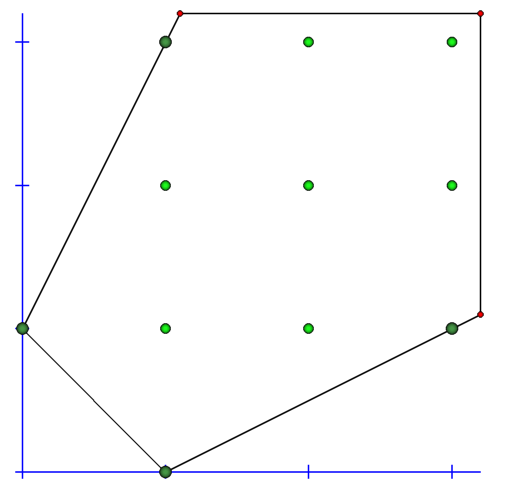<img>

Note that the upper right part (including the red vertices) arises from truncation of the polyhedron for visualization.


### Mixed-Integer Case

Let us now briefly discuss how to proceed if there are variables that are allowed to be integral. In this case there are several different types of information that one might be interested in. Let us first consider the question of how to compute the convex hull of all feasible integral variables, i.e., we consider the projection to the integral variables and then consider the convex hull of all feasible solutions. We only consider the bounded case, i.e., the original polyhedron is bounded.

Consider the following example:

    
    Minimize
     obj:  x1 + x2
    Subject to
    C1: s1 - 10 x1 <= 0
    C2: s2 - 10 x2 <= 0
    C3: s1 + s2 <= 1.5
    C4: s1 + s2 >= 0.5
    Bounds
     0 <= s1
     0 <= s2
     0 <= x1 <= 1
     0 <= x2 <= 1
    General
     x1 x2
    End

In this example there are two integral variables `x1` and `x2`, while `s1` and `s2` are continuous variables. Assuming the data is contained in the file `mip.lp`, we proceed as follows:

In [23]:
$m=lp2poly('files/optimization/mip.lp');
$p = new Polytope<Rational>($m);


We project the polyhedron in `$p` to the third and fourth variables as follows:

    


In [24]:
$q=projection($p, [3,4]);


We now construct the convex hull of all feasible points as above:

    


In [25]:
$s=new Polytope(POINTS=>$q->LATTICE_POINTS);
print_constraints($s);

Facets:
0: x1 + x2 >= 1
1: -x1 >= -1
2: -x2 >= -1



Thus, as expected, the convex hull equals the triangle with vertices `{(0,1),(1,0),(1,1)}`.

## Integral Polytopes and Total Unimodularity

As explained in the previous example, the integral points in a polytope are of particular interest in discrete optimization. These points are called *lattice points* in polymake and the corresponding convex hull *lattice polytope*. The handling of such polytopes is explained in more detail in the [Tutorial for Lattice Polytopes](lattice_polytopes_tutorial).

Of particular interest for discrete optimization are properties of the original inequality system to define a lattice polytope, i.e., a polytope such that all of its vertices are integral (this can be tested by checking the property `LATTICE`). One particularly interesting case occurs if the matrix defining the polytope is *totally unimodular* and the right hand side is integral.

Using the polymake extension [Unimodularity](https://github.com/xammy/unimodularity-test/wiki/Polymake-Extension) by Matthias Walter, this can be checked as illustrated in the following examples.

### Example: Explicit Matrix

In a first example, we directly create an integral matrix

    


In [26]:
$M=new Matrix<Integer>([[1,1,0,0],[1,0,1,0],[1,0,0,1]]);


The total unimodularity of this matrix can be checked as follows:

    


In [27]:
print totally_unimodular($M);

true

Thus, the given matrix is totally unimodular.

### Example: Matrix from Input

In the second example, we reuse the file `c3t` from the example above. We read it into polymake:

    


In [28]:
$f=lp2poly('files/optimization/c3t.lp');
$p = new Polytope<Rational>($f);


We now want to check whether the constraint matrix defined by the inequalities is totally unimodular (note that there are no equations in this example). Thus we first extract the inequality matrix without the first column (as an integer matrix) and then perform the test:

    


In [29]:
$A = new Matrix<Integer>($p->INEQUALITIES->minor(All, ~[0]));
print totally_unimodular($A);

true

Thus, this matrix is totally unimodular as well.

## Total dual integrality

Computations with respect to total dual integrality (TDI) can also be performed in polymake. Currently (August 2013), you need the perpetual beta version of polymake to access this functionality.

The main functions are:

*  The function `totally_dual_integral` takes an inequality system (as a matrix) and checks whether it is totally dual integral.

*  The function `make_totally_dual_integral` takes a polytope and returns a new polytope with inequalities that are TDI.

Note that the input has to be full-dimensional in order to use these functions.

To demonstrate the behavior of these functions, consider the 5-cycle example from above again:

    
    Maximize
     obj: x#1 + x#2 + x#3 + x#4 + x#5
    Subject to
     edge_1: x#2 + x#1 <= 1
     edge_2: x#3 + x#2 <= 1
     edge_3: x#4 + x#3 <= 1
     edge_4: x#5 + x#4 <= 1
     edge_5: x#1 + x#5 <= 1
    Bounds
     0 <= x#1 <= 1
     0 <= x#2 <= 1
     0 <= x#3 <= 1
     0 <= x#4 <= 1
     0 <= x#5 <= 1
    General
     x#1 x#2 x#3 x#4 x#5
    End


Let us test whether the inequality system of this example is TDI. Thus, we first load the data as usual:

    


In [30]:
$f = lp2poly('files/optimization/stab.lp');
$p = new Polytope<Rational>($f);


We now extract the corresponding inequality system and check it for TDIness:

    


In [31]:
$M = new Matrix<Rational>($p->INEQUALITIES);
print totally_dual_integral($M);

false

Click here for additional output 
 
polymake: used package libnormaliz
 [[wiki:external_software#Normaliz]] is a tool for computations in affine monoids, vector configurations, lattice polytopes, and rational cones.
 Copyright by Winfried Bruns, Bogdan Ichim, Christof Soeger.
 http://www.math.uos.de/normaliz/

The system is not TDI, which we expected from general theory, since we know that the polytope is not integral, but the system has integral coefficients. Consequently, let us construct a TDI-system for this polytope:

    


In [32]:
$q = make_totally_dual_integral($p);
print_constraints($q);

Inequalities:
0: x5 >= 0
1: x4 >= 0
2: x3 >= 0
3: x2 >= 0
4: x1 >= 0
5: -x1 - x2 >= -1
6: -x1 - x5 >= -1
7: -x2 - x3 >= -1
8: -x3 - x4 >= -1
9: -x4 - x5 >= -1
10: -x1 - x2 - x3 - x4 - x5 >= -5/2
11: 0 >= -1



As expected, the right hand side is non integral (otherwise, we know from general theory that the polytope would be integral as well). The result is now TDI:

    


In [33]:
$N = new Matrix<Rational>($q->INEQUALITIES);
print totally_dual_integral($N);

true

*Note* that we need to take the inequalities instead of facets here, since facets are irredundant and thus might not be TDI, although the complete set of inequalities is TDI.


## Chvátal-Gomory Closure

In the following we want to briefly show how closures of polytopes with respect to certain cutting-plane operators can be computed. We consider the two well-known cutting-plane operators here. The first one is the Chvátal-Gomory generator and the second one is the Lift-and-project operator as defined by Balas. For simplicity we will assume that the considered polytope is full-dimensional. 

### Chvátal-Gomory Closure - Example 1

We first consider the polytope from the stable set problem from above:

    
    Maximize
     obj: x#1 + x#2 + x#3 + x#4 + x#5
    Subject to
     edge_1: x#2 + x#1 <= 1
     edge_2: x#3 + x#2 <= 1
     edge_3: x#4 + x#3 <= 1
     edge_4: x#5 + x#4 <= 1
     edge_5: x#1 + x#5 <= 1
    Bounds
     0 <= x#1 <= 1
     0 <= x#2 <= 1
     0 <= x#3 <= 1
     0 <= x#4 <= 1
     0 <= x#5 <= 1
    General
     x#1 x#2 x#3 x#4 x#5
    End

As before we read in the file using `lp2poly`:

    


In [34]:
$f = lp2poly('files/optimization/stab.lp');
$p = new Polytope<Rational>($f);



The Chvátal-Gomory closure of a polytope can be computed with the function `gc_closure`. The function takes a full-dimensional polytope and returns a new polytope. This contains the system of inequalities defining the closure in the property `INEQUALITIES`. For our example, we obtain:

    


In [35]:
$g = gc_closure($p);
print print_constraints($g);

Inequalities:
0: x5 >= 0
1: x4 >= 0
2: x3 >= 0
3: x2 >= 0
4: x1 >= 0
5: -x1 - x2 >= -1
6: -x1 - x5 >= -1
7: -x2 - x3 >= -1
8: -x3 - x4 >= -1
9: -x4 - x5 >= -1
10: -x1 - x2 - x3 - x4 - x5 >= -2
11: 0 >= -1



Let us check whether the resulting polytope is integral:

    


In [36]:
print $g->LATTICE;

true

Thus, in this case, we have obtained the integer hull by one step of the Chvatal-Gomory-closure.

### Chvátal-Gomory Closure - Example 2

Let us now consider the classical example of a polytope with the vertices of simplex in d dimensions and the point 1/2 times (1, ..., 1). It can be shown that such a polytope has rank at least log(d) - 1, see [Pokutta, 2011](http://www.box.net/shared/at1y8i3pq434bxt6m9xm)]. In our example, we use d = 4:

    


In [37]:
$M = new Matrix<Rational>([[1,0,0,0,0],[1,1,0,0,0],[1,0,1,0,0],[1,0,0,1,0],[1,0,0,0,1],[1,1/2,1/2,1/2,1/2]]);
$t = new Polytope<Rational>(POINTS => $M);
$t1 = gc_closure($t);
$t1->FACETS;
print_constraints($t1);

Facets:
0: x4 >= 0
1: x3 >= 0
2: x2 >= 0
3: x1 >= 0
4: -x1 - x2 - x3 >= -1
5: -x1 - x2 - x4 >= -1
6: -x1 - x3 - x4 >= -1
7: -x2 - x3 - x4 >= -1



In [38]:
print $t1->LATTICE;

false

Thus, one round was not enough to produce an integral polytope. Indeed, the vertices are

    


In [39]:
$t1->VERTICES;
print $t1->VERTICES;

1 1/3 1/3 1/3 1/3
1 0 0 0 1
1 0 0 0 0
1 0 0 1 0
1 0 1 0 0
1 1 0 0 0



However, one more round is enough:

    


In [40]:
$t2 = gc_closure($t1);
$t2->FACETS;
print_constraints($t2);

Facets:
0: x4 >= 0
1: x3 >= 0
2: x2 >= 0
3: x1 >= 0
4: -x1 - x2 - x3 - x4 >= -1



In [41]:
print $t2->LATTICE;

true


## Lift-and-project closure

The lift-and-project closure of a 0/1-polytope P can be generated as follows: for each coordinate compute the intersection of P with the pair of opposite cube faces and compute the convex hull. Then intersect the result with P. The following script defines a subroutine performing this operation - the code is somewhat complicated throught the fact that we need to check whether parts are empty.

```perl
use application "polytope";

sub lpclosure
{
    my $p = shift;
    my $d = $p->AMBIENT_DIM;
    my $q = new Polytope<Rational>($p);
    for (my $k = 0; $k < $d; $k = $k+1)
    {
        if ( $q->DIM == -1 )         # can stop as soon as $q is empty
        {
             return $q;
        }
    
        # create reversed opposite inequalities of 0/1-cube and corresponding polyhedra
        my $v1 = new Vector<Rational>(0 | -unit_vector($d, $k));
        my $v2 = new Vector<Rational>(-1 | unit_vector($d, $k));
    
        # create intersection of corresponding polyhedra with iterated polyhedron $q
        my $b1 = new Polytope<Rational>(INEQUALITIES => $v1 / $q->FACETS);
        my $b2 = new Polytope<Rational>(INEQUALITIES => $v2 / $q->FACETS);
    
        if ( ($b1->DIM > -1) && ($b2->DIM > -1) )
        {
            my $c = conv($b1, $b2);
            $q = intersection($q, $c);
        }
        elsif ( ($b1->DIM > -1) && ($b2->DIM == -1) )
        {
            $q = intersection($q, $b1);
        }
        elsif ( ($b1->DIM == -1) && ($b2->DIM > -1) )
        {
            $q = intersection($q, $b2);
        }
    }
    return $q;
}
```

In [42]:
script("files/optimization/lpclosure.pl");

### Lift-and-Project Closure - Example 1

For our well known stable set example, we get the following:

In [43]:
$q = lpclosure($p);
$q->FACETS;
print_constraints($q);

Facets:
0: -x2 - x3 >= -1
1: x1 >= 0
2: -x3 - x4 >= -1
3: x5 >= 0
4: x3 >= 0
5: -1/2 x1 - 1/2 x2 - 1/2 x3 - 1/2 x4 - 1/2 x5 >= -1
6: x4 >= 0
7: -x4 - x5 >= -1
8: -x1 - x5 >= -1
9: x2 >= 0
10: -x1 - x2 >= -1



Thus, the lift-and-project closure in this case gives the integral hull (as we have seen above).

### Lift-and-Project Closure - Example 2

Let us now consider the same example as for CG-closures:

    


In [44]:
$M = new Matrix<Rational>([[1,0,0,0,0],[1,1,0,0,0],[1,0,1,0,0],[1,0,0,1,0],[1,0,0,0,1],[1,1/2,1/2,1/2,1/2]]);
$p = new Polytope<Rational>(POINTS => $M);
$q = lpclosure($p);
$q->FACETS;
print_constraints($q);

Facets:
0: x1 >= 0
1: x2 >= 0
2: -x1 - x2 - x3 - x4 >= -1
3: x4 >= 0
4: x3 >= 0



Thus, we have obtained the integral hull in a single step of the lift-and-project closure as opposed to two steps in the CG-closure.





